# Sales & Demand Forecasting (Future Interns – Task 1)

Dataset: Sample – Superstore (orders from 2014–2017)  



# **Holt Winters**

# **1) Setup, imports, and data loading**

In [6]:
# If running in a fresh environment, install common libs (uncomment if needed)
# !pip -q install pandas numpy matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
# Load Pandas
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [7]:
# metric helper (no dependency on sklearn version)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100


# Load Superstore
df = pd.read_csv("Sample - Superstore.csv", encoding="ISO-8859-1")
df.head()# metric helper (no dependency on sklearn version)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100


# Load Superstore
df = pd.read_csv("Sample - Superstore.csv", encoding="ISO-8859-1")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


## 1) Clean & prepare the data



In [8]:
# Parse dates and build daily sales
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
df = df.dropna(subset=["Order Date"])

daily_sales = (
    df.groupby("Order Date")["Sales"]
      .sum()
      .asfreq("D")
      .fillna(0.0)
      .rename("y")
)

daily_sales.head(), daily_sales.index.min(), daily_sales.index.max()

(Order Date
 2014-01-03      16.448
 2014-01-04     288.060
 2014-01-05      19.536
 2014-01-06    4407.100
 2014-01-07      87.158
 Freq: D, Name: y, dtype: float64,
 Timestamp('2014-01-03 00:00:00'),
 Timestamp('2017-12-30 00:00:00'))

## 2) Quick exploration (trend + seasonality)



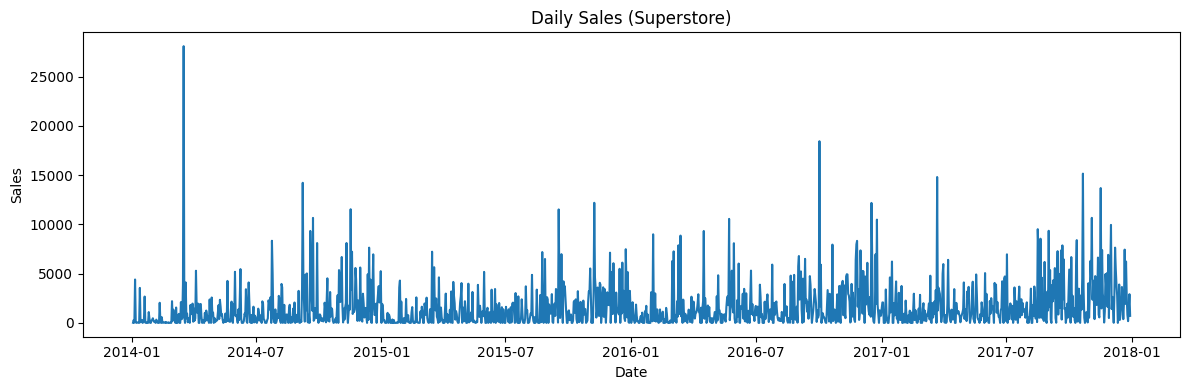

In [9]:
plt.figure(figsize=(12,4))
plt.plot(daily_sales)
plt.title("Daily Sales (Superstore)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()


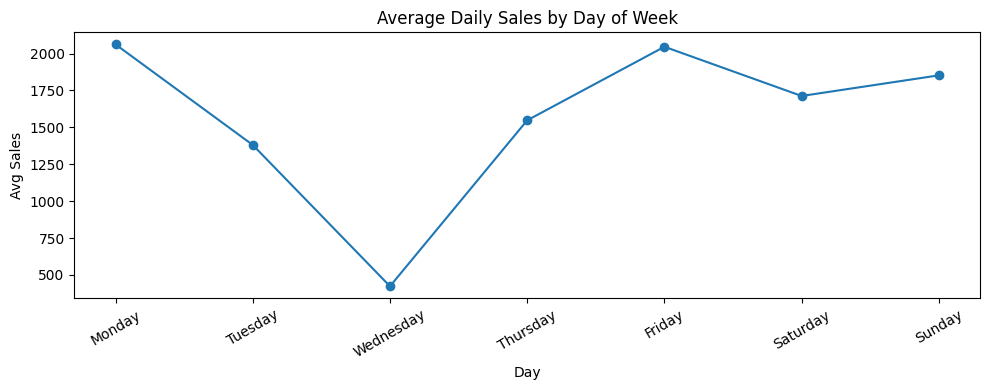

In [10]:
# Quick look at weekly pattern by day-of-week
dow = daily_sales.groupby(daily_sales.index.day_name()).mean()
dow = dow.reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

plt.figure(figsize=(10,4))
plt.plot(dow.index, dow.values, marker="o")
plt.title("Average Daily Sales by Day of Week")
plt.xlabel("Day")
plt.ylabel("Avg Sales")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


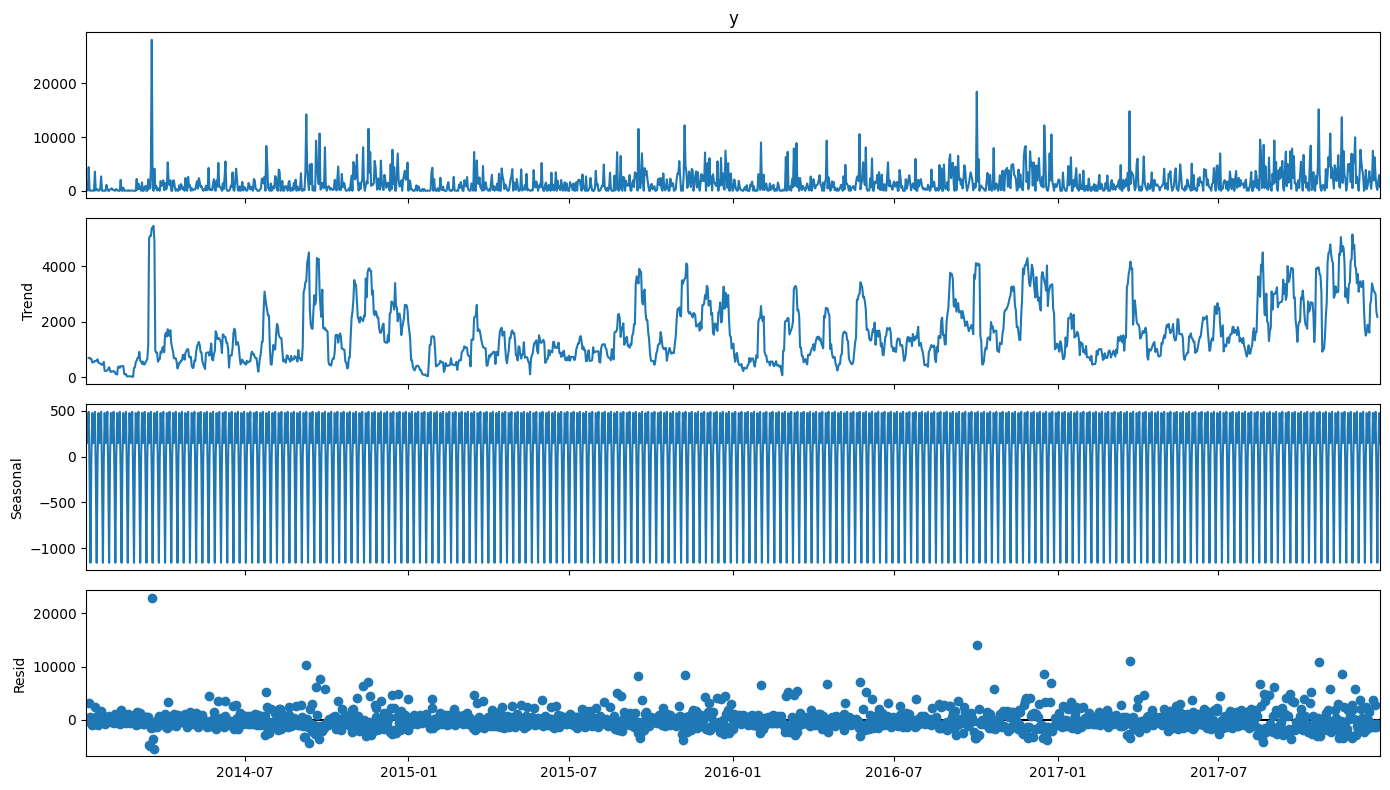

In [11]:
# Decomposition on DAILY series:
# period=7 captures weekly seasonality on daily data
decomp_daily = seasonal_decompose(daily_sales, model="additive", period=7)
fig = decomp_daily.plot()
fig.set_size_inches(14, 8)
plt.tight_layout()
plt.show()

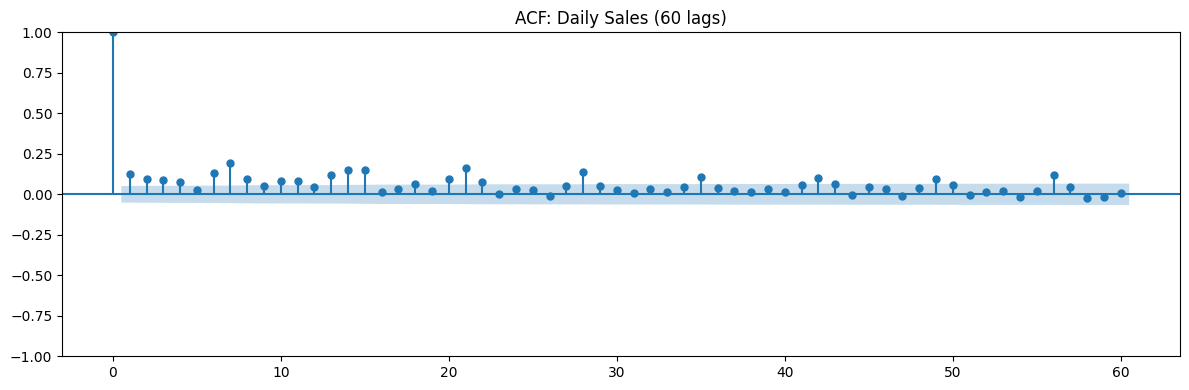

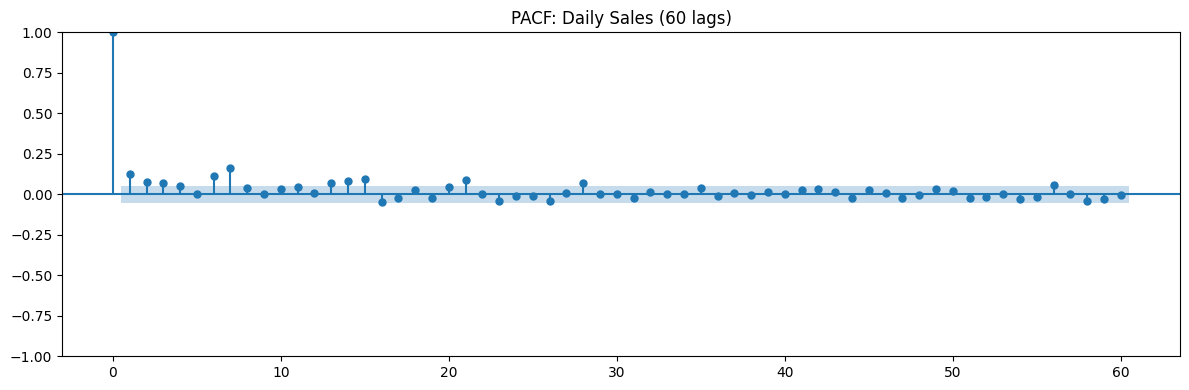

In [12]:
# ACF / PACF on DAILY series (60 lags)
fig, ax = plt.subplots(figsize=(12,4))
plot_acf(daily_sales, lags=60, ax=ax)
ax.set_title("ACF: Daily Sales (60 lags)")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12,4))
plot_pacf(daily_sales, lags=60, ax=ax, method="ywm")
ax.set_title("PACF: Daily Sales (60 lags)")
plt.tight_layout()
plt.show()


## 3) Set weekly frequency



In [13]:
# Weekly total sales (Monday-anchored weeks)
weekly_sales = daily_sales.resample("W-MON").sum().asfreq("W-MON").rename("y")
weekly_sales.head(), weekly_sales.index.freq


(Order Date
 2014-01-06    4731.144
 2014-01-13    3746.267
 2014-01-20    3629.202
 2014-01-27    1595.188
 2014-02-03    1312.752
 Freq: W-MON, Name: y, dtype: float64,
 <Week: weekday=0>)

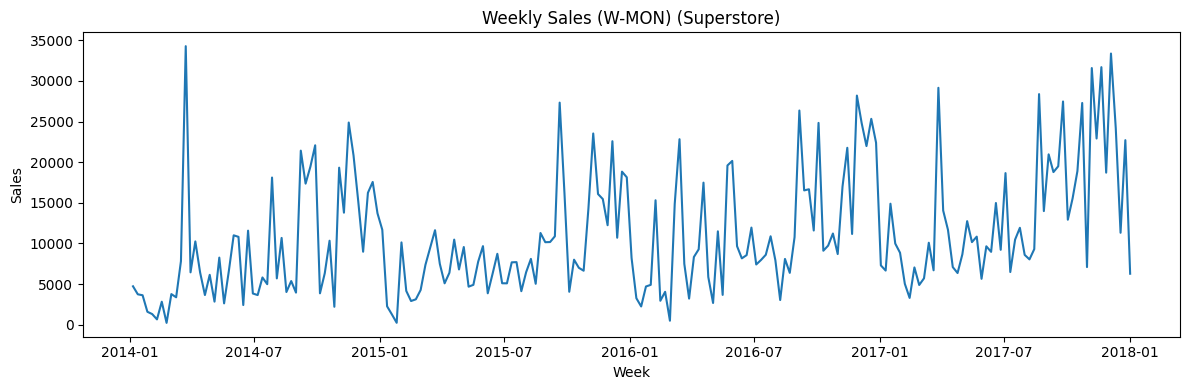

In [14]:
plt.figure(figsize=(12,4))
plt.plot(weekly_sales)
plt.title("Weekly Sales (W-MON) (Superstore)")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()


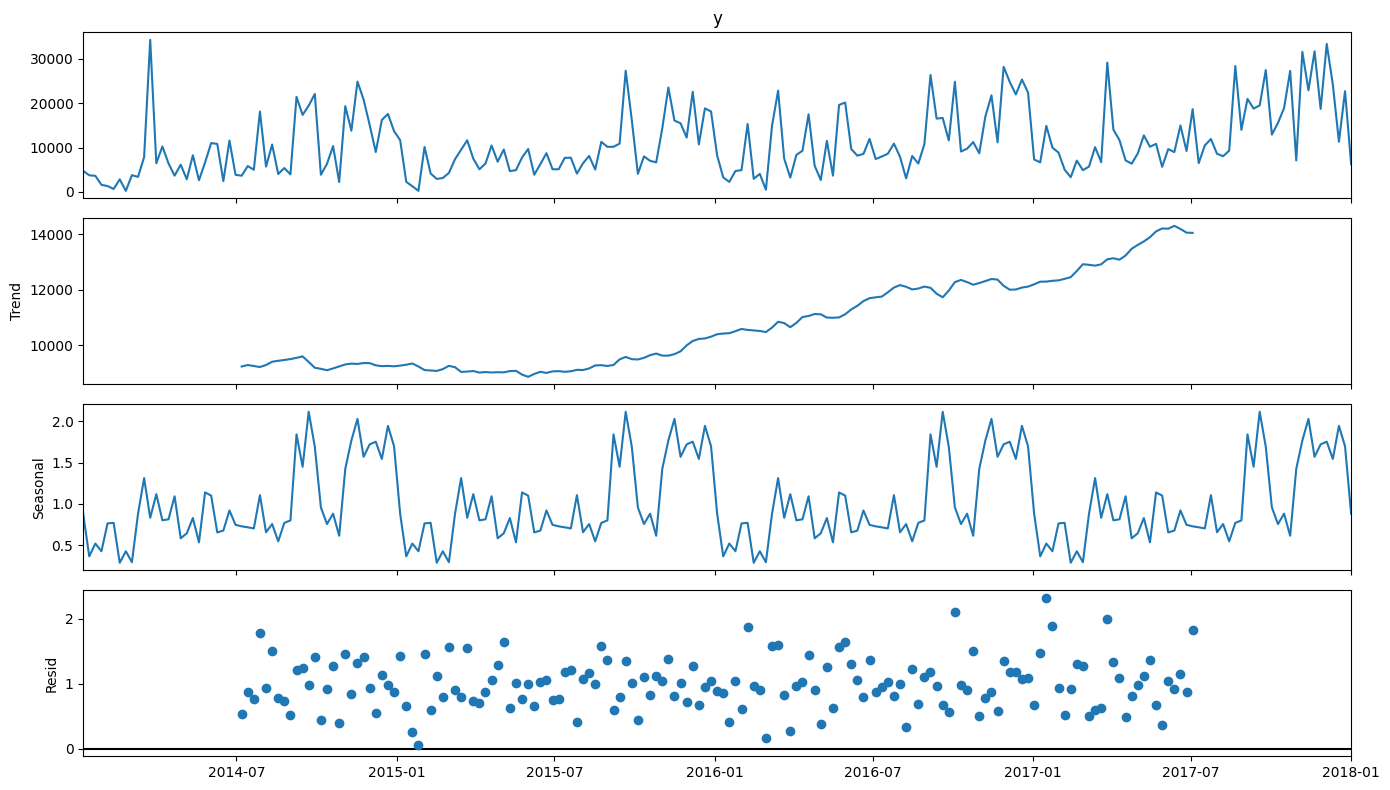

In [15]:
# Decomposition on WEEKLY series with yearly seasonality:
# period=52 weeks per year
decomp_weekly = seasonal_decompose(weekly_sales, model="multiplicative", period=52)
fig = decomp_weekly.plot()
fig.set_size_inches(14, 8)
plt.tight_layout()
plt.show()


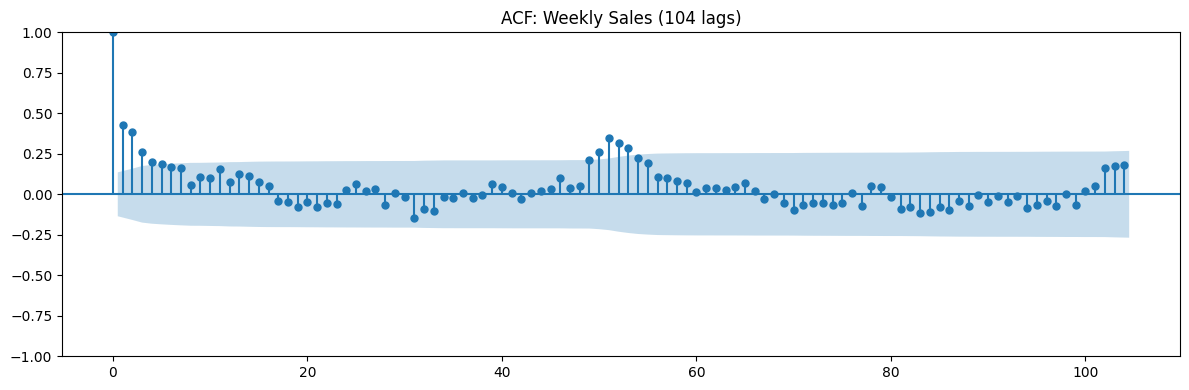

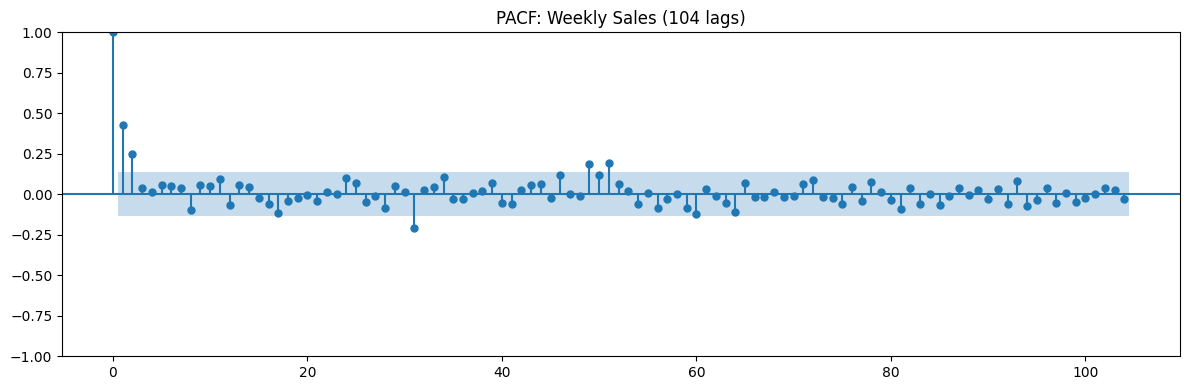

In [16]:
# ACF / PACF on WEEKLY series
fig, ax = plt.subplots(figsize=(12,4))
plot_acf(weekly_sales, lags=104, ax=ax)
ax.set_title("ACF: Weekly Sales (104 lags)")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12,4))
plot_pacf(weekly_sales, lags=104, ax=ax, method="ywm")
ax.set_title("PACF: Weekly Sales (104 lags)")
plt.tight_layout()
plt.show()


## 4) Train/Test split (time-based)




In [17]:
periods = 13  # 13-week horizon

train = weekly_sales.iloc[:-periods]
test  = weekly_sales.iloc[-periods:]

train.index.min(), train.index.max(), test.index.min(), test.index.max()


(Timestamp('2014-01-06 00:00:00'),
 Timestamp('2017-10-02 00:00:00'),
 Timestamp('2017-10-09 00:00:00'),
 Timestamp('2018-01-01 00:00:00'))

## 5) Simple Exponential Smoothing (SES)


In [18]:
ses_model = SimpleExpSmoothing(train).fit(optimized=True)
ses_pred = ses_model.forecast(periods)

ses_model.params, ses_pred.head()


({'smoothing_level': np.float64(0.27334100800581057),
  'smoothing_trend': np.float64(nan),
  'smoothing_seasonal': np.float64(nan),
  'damping_trend': nan,
  'initial_level': np.float64(4731.144),
  'initial_trend': np.float64(nan),
  'initial_seasons': array([], dtype=float64),
  'use_boxcox': False,
  'lamda': None,
  'remove_bias': False},
 2017-10-09    18323.6027
 2017-10-16    18323.6027
 2017-10-23    18323.6027
 2017-10-30    18323.6027
 2017-11-06    18323.6027
 Freq: W-MON, dtype: float64)

# 6) **Double Exponential Smoothing (Holt’s Linear Trend)**

In [19]:
holt_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal=None
).fit(optimized=True)

holt_pred = holt_model.forecast(periods)
holt_model.params, holt_pred.head()


({'smoothing_level': np.float64(0.2655434367424216),
  'smoothing_trend': np.float64(0.0),
  'smoothing_seasonal': np.float64(nan),
  'damping_trend': nan,
  'initial_level': np.float64(3453.8048090928683),
  'initial_trend': np.float64(76.9359197076943),
  'initial_seasons': array([], dtype=float64),
  'use_boxcox': False,
  'lamda': None,
  'remove_bias': False},
 2017-10-09    18563.566039
 2017-10-16    18640.501959
 2017-10-23    18717.437878
 2017-10-30    18794.373798
 2017-11-06    18871.309718
 Freq: W-MON, dtype: float64)

## 7) Holt-Winters (Triple ES, trend + seasonality)



In [20]:
# Multiplicative seasonality is usually reasonable for sales (seasonality scales with level).
# If your seasonal component looks constant in size, switch seasonal="add".

hw_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal="mul",
    seasonal_periods=52
).fit(optimized=True)

hw_pred = hw_model.forecast(periods)
hw_model.params, hw_pred.head()


({'smoothing_level': np.float64(1.4901161193847656e-08),
  'smoothing_trend': np.float64(1.48878116543626e-08),
  'smoothing_seasonal': np.float64(0.0),
  'damping_trend': nan,
  'initial_level': np.float64(9159.58843781029),
  'initial_trend': np.float64(28.40879575756197),
  'initial_seasons': array([0.69151747, 0.35511975, 0.51906586, 0.39310324, 0.55998411,
         0.56721896, 0.25605662, 0.33425987, 0.28254107, 0.6778103 ,
         1.08019425, 1.14301271, 1.05071774, 0.80515136, 0.72616949,
         0.82492577, 0.52076065, 0.50362208, 0.79154377, 0.46633738,
         0.95001267, 0.94359851, 0.69665451, 0.55249057, 0.90307947,
         0.63881898, 0.76224925, 0.56663127, 0.66084346, 0.89049636,
         0.58684132, 0.58159051, 0.55073314, 1.0999557 , 0.80847877,
         1.58142471, 1.26829031, 1.62405923, 1.53602892, 0.95300835,
         0.66517896, 0.75315419, 0.59007515, 1.13877271, 1.51531537,
         1.72288196, 1.27559818, 1.57189426, 1.59991165, 1.35858502,
         1.7122

# **8) Evaluation (RMSE/MAE/MAPE) and helper functions**

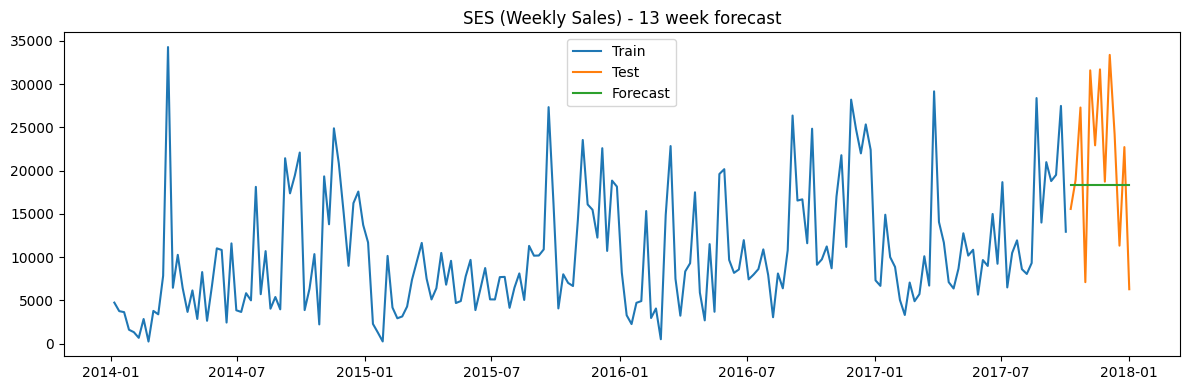

RMSE: 9,051.03
MAE : 7,655.91
MAPE: 50.82%


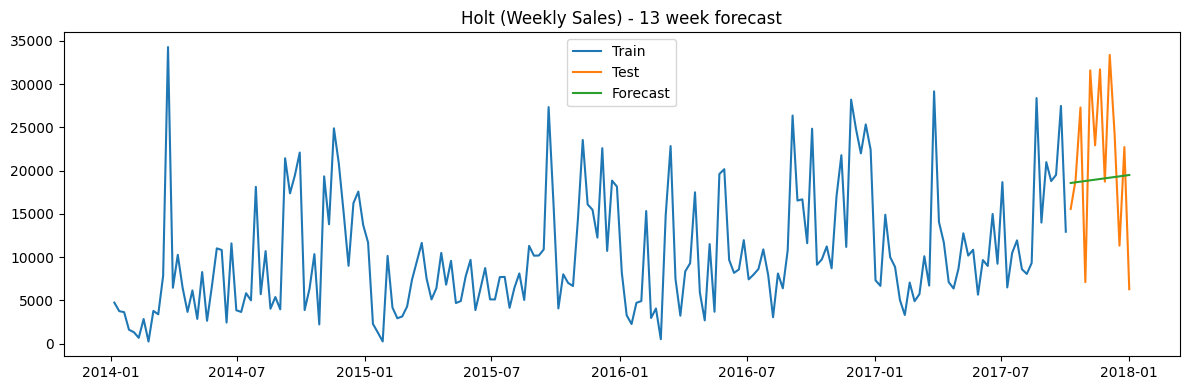

RMSE: 8,914.94
MAE : 7,457.12
MAPE: 51.94%


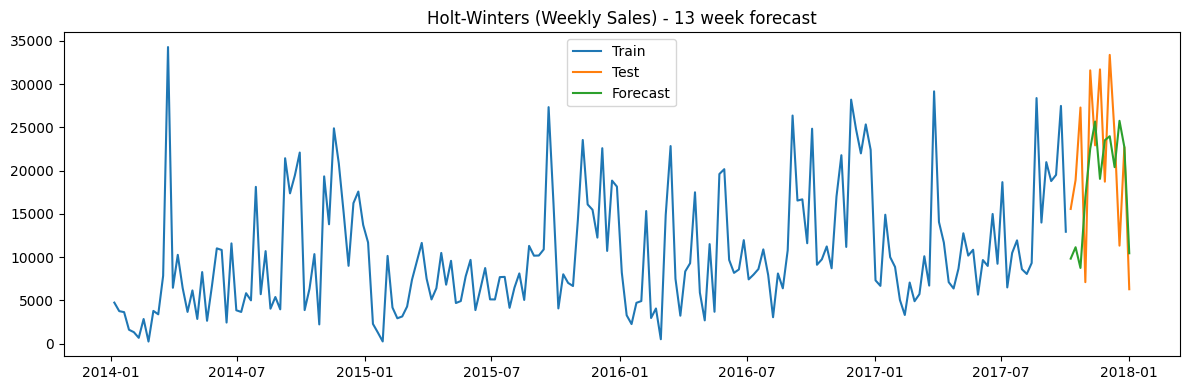

RMSE: 9,343.69
MAE : 7,917.95
MAPE: 48.31%


In [21]:
def assess(train_series, test_series, pred_series, title):
    plt.figure(figsize=(12,4))
    plt.plot(train_series, label="Train")
    plt.plot(test_series, label="Test")
    plt.plot(pred_series, label="Forecast")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

    r = rmse(test_series, pred_series)
    a = mean_absolute_error(test_series, pred_series)
    p = mape(test_series, pred_series)
    print(f"RMSE: {r:,.2f}")
    print(f"MAE : {a:,.2f}")
    print(f"MAPE: {p:,.2f}%")

assess(train, test, ses_pred,  "SES (Weekly Sales) - 13 week forecast")
assess(train, test, holt_pred, "Holt (Weekly Sales) - 13 week forecast")
assess(train, test, hw_pred,   "Holt-Winters (Weekly Sales) - 13 week forecast")


In [22]:
# Side-by-side metrics table
results = pd.DataFrame({
    "model": ["SES", "Holt", "Holt-Winters"],
    "RMSE":  [rmse(test, ses_pred), rmse(test, holt_pred), rmse(test, hw_pred)],
    "MAE":   [mean_absolute_error(test, ses_pred), mean_absolute_error(test, holt_pred), mean_absolute_error(test, hw_pred)],
    "MAPE%": [mape(test, ses_pred), mape(test, holt_pred), mape(test, hw_pred)]
}).sort_values("RMSE")

results


,model,RMSE,MAE,MAPE%
1,Holt,8914.943587,7457.119108,51.939111
0,SES,9051.029532,7655.907223,50.817511
2,Holt-Winters,9343.685450,7917.945993,48.313326


## 9) Refit on full history and forecast the future




In [23]:
best_model = ExponentialSmoothing(
    weekly_sales,
    trend="add",
    seasonal="mul",
    seasonal_periods=52
).fit(optimized=True)

future_weeks = 13
future_forecast = best_model.forecast(future_weeks)

future_forecast.head(), future_forecast.index.min(), future_forecast.index.max()


(2018-01-08    5617.686781
 2018-01-15    8310.469291
 2018-01-22    6317.618583
 2018-01-29    8911.458263
 2018-02-05    9068.730430
 Freq: W-MON, dtype: float64,
 Timestamp('2018-01-08 00:00:00'),
 Timestamp('2018-04-02 00:00:00'))

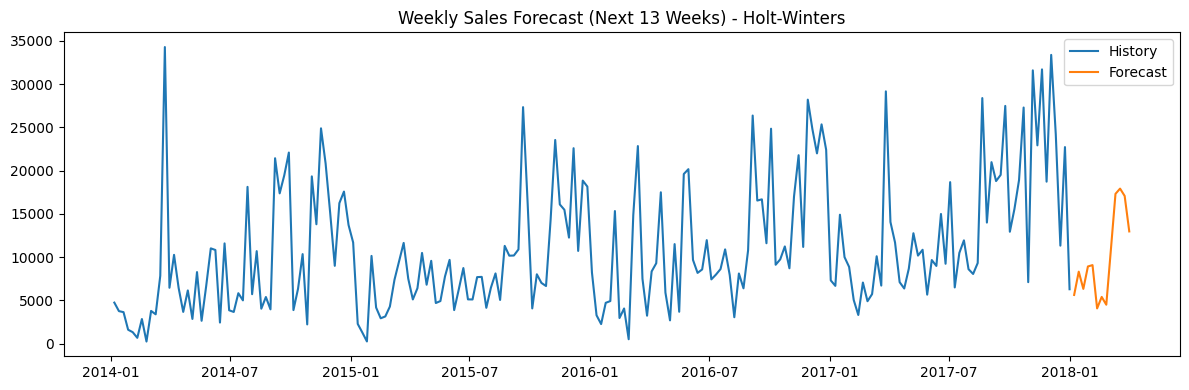

In [24]:
plt.figure(figsize=(12,4))
plt.plot(weekly_sales, label="History")
plt.plot(future_forecast, label="Forecast")
plt.title("Weekly Sales Forecast (Next 13 Weeks) - Holt-Winters")
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
# Save forecast for submission
out = pd.DataFrame({"week": future_forecast.index, "forecast_sales": future_forecast.values})
out.to_csv("superstore_weekly_forecast_13_weeks.csv", index=False)
out.head()


,week,forecast_sales
0,2018-01-08,5617.686781
1,2018-01-15,8310.469291
2,2018-01-22,6317.618583
3,2018-01-29,8911.458263
4,2018-02-05,9068.730430


In [26]:
model_holt = ExponentialSmoothing(
    endog=train,
    trend="add",
    seasonal="mul",
    seasonal_periods=52
).fit()


In [28]:
import os
import pickle

os.makedirs("models", exist_ok=True)

# Use the SAME variable names you used in your notebook:
# ses_model  -> fitted SimpleExpSmoothing model
# holt_model -> fitted Holt (double ES) model
# hw_model   -> fitted Holt-Winters model

with open("models/ses.pkl", "wb") as f:
    pickle.dump(ses_model, f)

with open("models/holt.pkl", "wb") as f:
    pickle.dump(holt_model, f)

with open("models/holt_winters.pkl", "wb") as f:
    pickle.dump(hw_model, f)

print("Saved: models/ses.pkl, models/holt.pkl, models/holt_winters.pkl")


Saved: models/ses.pkl, models/holt.pkl, models/holt_winters.pkl
